In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.spatial import Voronoi, voronoi_plot_2d
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('data/train.csv')

C:\Users\qbenj\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(np.unique(raw_data['PlayId'].values).size)
print(raw_data.columns)

23171
Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')


In [4]:
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())

In [5]:
#FieldPosition and PossessionTeam use ARZ, BLT, CLV, HST and VisitorTeamAbbr and HomeTeamAbbr use ARI, BAL, CLE, HOU
raw_data[['PossessionTeam', 'FieldPosition']] = raw_data[['PossessionTeam', 'FieldPosition']].replace(['ARZ', 'BLT', 'CLV', 'HST'], ['ARI', 'BAL', 'CLE', 'HOU'])

#To Do: Deal with missing FieldPosition Labels?

#Normalize direction and position
raw_data['ToLeft'] = raw_data['PlayDirection'] == 'left'
raw_data['IsBallCarrier'] = raw_data['NflId'] == raw_data['NflIdRusher']
raw_data['TeamOnOffense'] = np.where(raw_data['PossessionTeam'] == raw_data['HomeTeamAbbr'], 'home', 'away')
raw_data['IsOnOffense'] = raw_data['Team'] == raw_data['TeamOnOffense']
raw_data['YardsFromOwnGoal'] = np.where(raw_data['FieldPosition'] == raw_data['PossessionTeam'], raw_data['YardLine'], 50 + (50 - raw_data['YardLine']))
raw_data['X_std'] = np.where(raw_data['ToLeft'], 120-raw_data['X'], raw_data['X']) - 10
raw_data['Y_std'] = np.where(raw_data['ToLeft'], 160/3-raw_data['Y'], raw_data['Y'])

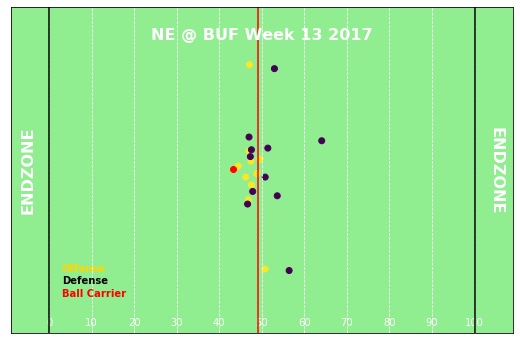

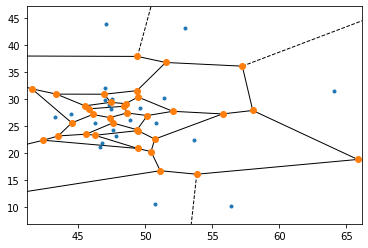

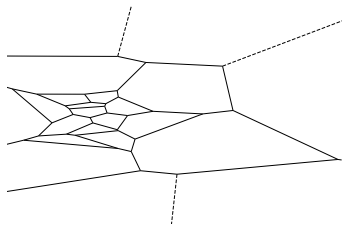

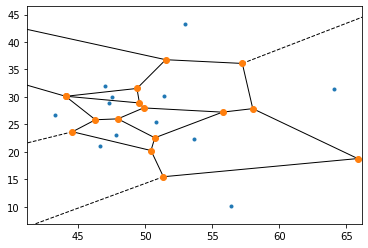

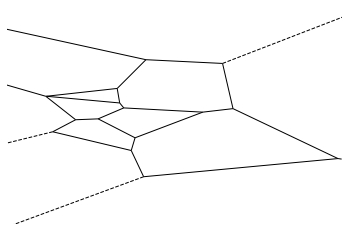

In [6]:
#Plot plays 1 big gain

Example1=20171203021363
Play1=raw_data[raw_data['PlayId']==Example1]
Runner1=Play1[Play1['IsBallCarrier']==True]
plt.figure(figsize=(9,6)) #was 10,6
PlayPlot1=plt.scatter(Play1['X_std'], Play1['Y_std'], c=Play1['IsOnOffense'])
ax=plt.gca()
plt.axis([-9, 109, 0, 160/3])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(axis="x",direction="in", pad=-15, colors='white')
ax.set_facecolor('lightgreen')
plt.axvline(x=Play1['YardsFromOwnGoal'].iloc[0], c='r')
plt.axvline(x=0, c='black')
plt.axvline(x=100, c='black')
plt.scatter(Runner1['X_std'], Runner1['Y_std'], c='red')
ax.xaxis.grid(which='major', linestyle='--', c='w')
plt.yticks([])
ax.text(.5,.9,
            Play1['VisitorTeamAbbr'].iloc[0]
            +' @ '+Play1['HomeTeamAbbr'].iloc[0] 
            +' Week '+str(Play1['Week'].iloc[0])
            + ' ' 
            +str(Play1['Season'].iloc[0]),
        horizontalalignment='center', transform=ax.transAxes, c='white', fontsize=16, weight='bold')
ax.text(-5, 160/6, 'ENDZONE',  rotation=90, verticalalignment='center', horizontalalignment='center', color='white', fontsize=16, weight='bold')
ax.text(105, 160/6, 'ENDZONE',  rotation=-90, verticalalignment='center', horizontalalignment='center', color='white', fontsize=16, weight='bold')
ax.text(3, 10, 'Offense', color='gold', weight='bold')
ax.text(3, 8, 'Defense', color='black', weight='bold')
ax.text(3, 6, 'Ball Carrier', color='red', weight='bold')

#Offstat = Play1[Play1['IsOnOffense']==True].iloc[0]
#Off_team = 'HomeTeamAbbr' if Offstat['Team'] == 'home' else 'VisitorTeamAbbr'
#Def_team = 'VisitorTeamAbbr' if Offstat['Team'] == 'home' else 'HomeTeamAbbr'
#ax.text(5,40, 'Team: '+Offstat[Off_team])
#ax.text(5,38, 'Formation: '+Offstat['OffenseFormation'])
#ax.text(80,40, 'Team: '+Offstat[Def_team])
#ax.text(80,38, 'Def in Box: '+ str(Offstat['DefendersInTheBox']))


plt.show()

#Voronoi Diagrams

players=list(zip(Play1['X_std'], Play1['Y_std']))
vor=Voronoi(players)

vor1=voronoi_plot_2d(vor)
plt.show()

vor2 = voronoi_plot_2d(vor, show_points=False, show_vertices=False, line_width=1)
plt.axis('off')
plt.show()

#Showing only defensive players and the ball carrier

defense_vor = Play1[Play1['IsOnOffense'] == False]
ball_car_vor = Play1[Play1['IsBallCarrier'] == True]
defense_vor = defense_vor.append(ball_car_vor)
defense_vor = list(zip(defense_vor['X_std'], defense_vor['Y_std']))
def_vor = Voronoi(defense_vor)

vor3 = voronoi_plot_2d(def_vor)
plt.show()

vor4 = voronoi_plot_2d(def_vor, show_points=False, show_vertices=False, line_width=1)
plt.axis('off')
plt.show()



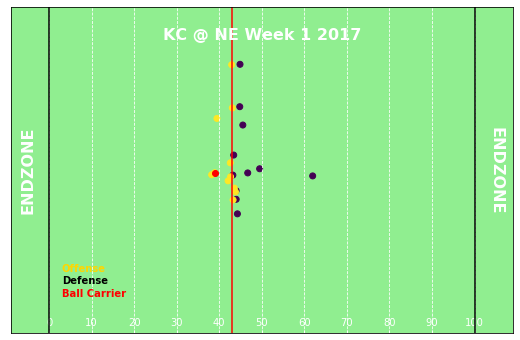

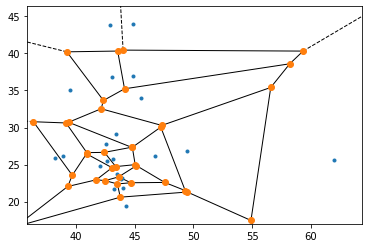

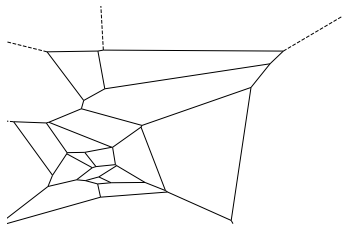

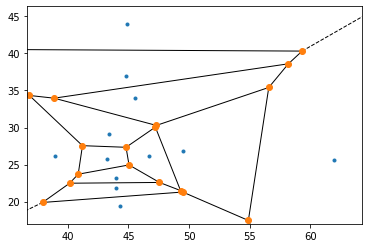

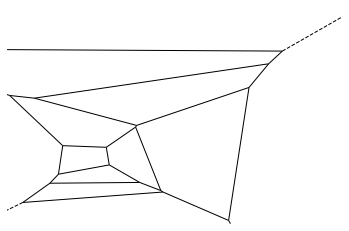

In [7]:
#Short gain example
#Example2=20171120000963
Example2=20170907000139
Play1=raw_data[raw_data['PlayId']==Example2]
Runner1=Play1[Play1['IsBallCarrier']==True]
plt.figure(figsize=(9,6)) #was 10,6
PlayPlot1=plt.scatter(Play1['X_std'], Play1['Y_std'], c=Play1['IsOnOffense'])
ax=plt.gca()
plt.axis([-9, 109, 0, 160/3])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(axis="x",direction="in", pad=-15, colors='white')
ax.set_facecolor('lightgreen')
plt.axvline(x=Play1['YardsFromOwnGoal'].iloc[0], c='r')
plt.axvline(x=0, c='black')
plt.axvline(x=100, c='black')
plt.scatter(Runner1['X_std'], Runner1['Y_std'], c='red')
ax.xaxis.grid(which='major', linestyle='--', c='w')
plt.yticks([])
ax.text(.5,.9,
            Play1['VisitorTeamAbbr'].iloc[0]
            +' @ '+Play1['HomeTeamAbbr'].iloc[0] 
            +' Week '+str(Play1['Week'].iloc[0])
            + ' ' 
            +str(Play1['Season'].iloc[0]),
        horizontalalignment='center', transform=ax.transAxes, c='white', fontsize=16, weight='bold')
ax.text(-5, 160/6, 'ENDZONE',  rotation=90, verticalalignment='center', horizontalalignment='center', color='white', fontsize=16, weight='bold')
ax.text(105, 160/6, 'ENDZONE',  rotation=-90, verticalalignment='center', horizontalalignment='center', color='white', fontsize=16, weight='bold')
ax.text(3, 10, 'Offense', color='gold', weight='bold')
ax.text(3, 8, 'Defense', color='black', weight='bold')
ax.text(3, 6, 'Ball Carrier', color='red', weight='bold')
plt.show()

#Voronoi Diagrams

players=list(zip(Play1['X_std'], Play1['Y_std']))
vor=Voronoi(players)

vor1=voronoi_plot_2d(vor)
plt.show()

vor2 = voronoi_plot_2d(vor, show_points=False, show_vertices=False, line_width=1)
plt.axis('off')
plt.show()

#Showing only defensive players and the ball carrier

defense_vor = Play1[Play1['IsOnOffense'] == False]
ball_car_vor = Play1[Play1['IsBallCarrier'] == True]
defense_vor = defense_vor.append(ball_car_vor)
defense_vor = list(zip(defense_vor['X_std'], defense_vor['Y_std']))
def_vor = Voronoi(defense_vor)

vor3 = voronoi_plot_2d(def_vor)
plt.show()

vor4 = voronoi_plot_2d(def_vor, show_points=False, show_vertices=False, line_width=1)
plt.axis('off')
plt.show()


In [8]:
#Directional Data

